In [ ]:
import numpy as np 
import pandas as pd 


import os

import warnings  
warnings.filterwarnings('ignore')

# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
import unidecode


#import os
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.feature_extraction.text import CountVectorizer
#import spacy
#import string
#import re
from google.colab import drive 
# import numpy as np
# import pandas as pd
# import plotly.express as px
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
#import nltk
#import operator
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Capstone Team 15 Drive/Work/')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /content/drive


In [ ]:
!pip install unidecode

     |████████████████████████████████| 245kB 12.2MB/s 


# Reading in data

In [ ]:
df = pd.read_csv("incident_download_Capstone_Project_2021-03-01.csv", encoding="ISO-8859-1")
df.head()

u_affected_application   sys_created_on  ... Unnamed: 18  1
0       Cisco AnyConnect  1/31/2021 23:56  ...         NaN  2
1                 Driver  1/31/2021 23:54  ...         NaN  3
2       Cisco AnyConnect  1/31/2021 23:53  ...         NaN  4
3       Cisco AnyConnect  1/31/2021 23:48  ...         NaN  5
4                    NaN  1/31/2021 23:42  ...         NaN  6

[5 rows x 20 columns]

In [ ]:
def costum_tokenize(text):
  try:
    text = re.sub('\W+',' ', text)
    text = word_tokenize(text)
  except TypeError:
    text = 'NaN'
  
  return text

def freq_count(col):
  frq_dic = {}
  for lst in col:
    for i in lst:
      if i not in stop_words and i.isalpha():
        if i in frq_dic:
          frq_dic[i] += 1
        else:
          frq_dic[i] = 1
  return frq_dic

def split1(text):
  try:
    t = text[:19]
    return t
  except TypeError:
    return None

def split2(text):
  try:
    text = text[19:]
    return text
  except TypeError:
    return None

def clean_review(review):
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))   
    return review.translate(replace_punctuation).lower()

def remodel (text):
  return ' '.join(word_tokenize(clean_review(text)))
  

In [ ]:
df2 = df[['category', 'short_description']].dropna()
#,"comments_and_work_notes"

In [ ]:
df2['category'].value_counts()

Application               45674
Hardware                  21088
VDI                       19196
Access                    15019
Telephony                 10240
End user equipment         7456
Mobile Device              6874
Integration                3492
Printing                   2919
Network                    2656
Monitoring                 1807
Store equipment            1346
Security                   1204
AV / Conf room              675
Facilities                  525
Server                      309
Database                    181
Data / Reporting            100
Storage                      82
Middleware                   31
Enterprise Application        3
Name: category, dtype: int64

In [ ]:
def cleanText(text):
    text = re.sub('\W+',' ', text)
    text = text.lower()
    return ' '.join([t for t in text.split() if t not in stop_words])

df2['short_description'] = df2['short_description'].apply(cleanText)
#df2['comments_and_work_notes'] = df2['comments_and_work_notes'].apply(cleanText)

In [ ]:
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [ ]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', #stop_words=stop_words1, 
                                               norm='l2', tokenizer=LemmaTokenizer())

# Random Sampling cross validation

In [ ]:
import random

In [ ]:
# X = df2.drop(['category'], axis=1)
# y = df2['category']
# x_train, y_train, x_test, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
train, test = train_test_split(df2, test_size = 0.33, random_state=42)
x_train = vec_tdidf.fit_transform(train['short_description'])
x_test = vec_tdidf.transform(test['short_description'])
y_train = train['category']
y_test = test['category']

In [ ]:
#clf = XGBClassifier(random_state=42, objective="softmax")
m = int(train.shape[0]*0.3)

estimators = [50,100,150,200,300]

score = []
for i in range(5):
  new_train = train.sample(m)
  validation = train[~train.index.isin(new_train.index)]
  
  xtrain = vec_tdidf.fit_transform(new_train['short_description'])
  xval = vec_tdidf.transform(validation['short_description'])

  ytrain = new_train['category']
  yval = validation['category']
  
  acc_score = []
  for j in estimators:
    clf = XGBClassifier(random_state=42, n_estimators = j, objective="multi:softmax") #multi:softmax
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xval)
    acc = metrics.accuracy_score(yval, ypred)
    acc_score.append(acc)
  
  avg_score = np.mean(acc_score)
  score.append(avg_score)

In [ ]:
xgest_scores = pd.DataFrame(columns=['n_estimators', 'accuracy'])
xgest_scores['n_estimators'] = estimators
xgest_scores['accuracy'] = score

In [ ]:
xgest_scores
xgest_scores.to_csv("xgest_scores")

In [ ]:

index = xgest_scores[xgest_scores['accuracy']==max(xgest_scores['accuracy'])].index.values

est = xgest_scores['n_estimators'][index[0]]

clf_best = XGBClassifier(random_state=42, n_estimators = est, objective="softmax")
clf_best.fit(x_train,y_train)
y_pred = clf_best.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.6547179632784402

In [ ]:
metrics.auc(y_test, y_pred)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

        AV / Conf room       0.87      0.42      0.56       201
                Access       0.63      0.31      0.41      4452
           Application       0.56      0.83      0.67     13747
      Data / Reporting       0.00      0.00      0.00        30
              Database       0.41      0.15      0.22        47
    End user equipment       0.59      0.35      0.44      2232
Enterprise Application       0.00      0.00      0.00         2
            Facilities       0.54      0.93      0.68       151
              Hardware       0.74      0.48      0.58      6306
           Integration       0.00      0.00      0.00      1025
            Middleware       0.00      0.00      0.00         8
         Mobile Device       0.75      0.67      0.71      2075
            Monitoring       0.73      0.77      0.75       536
               Network       0.66      0.32      0.43       815
              Printing       0.65      

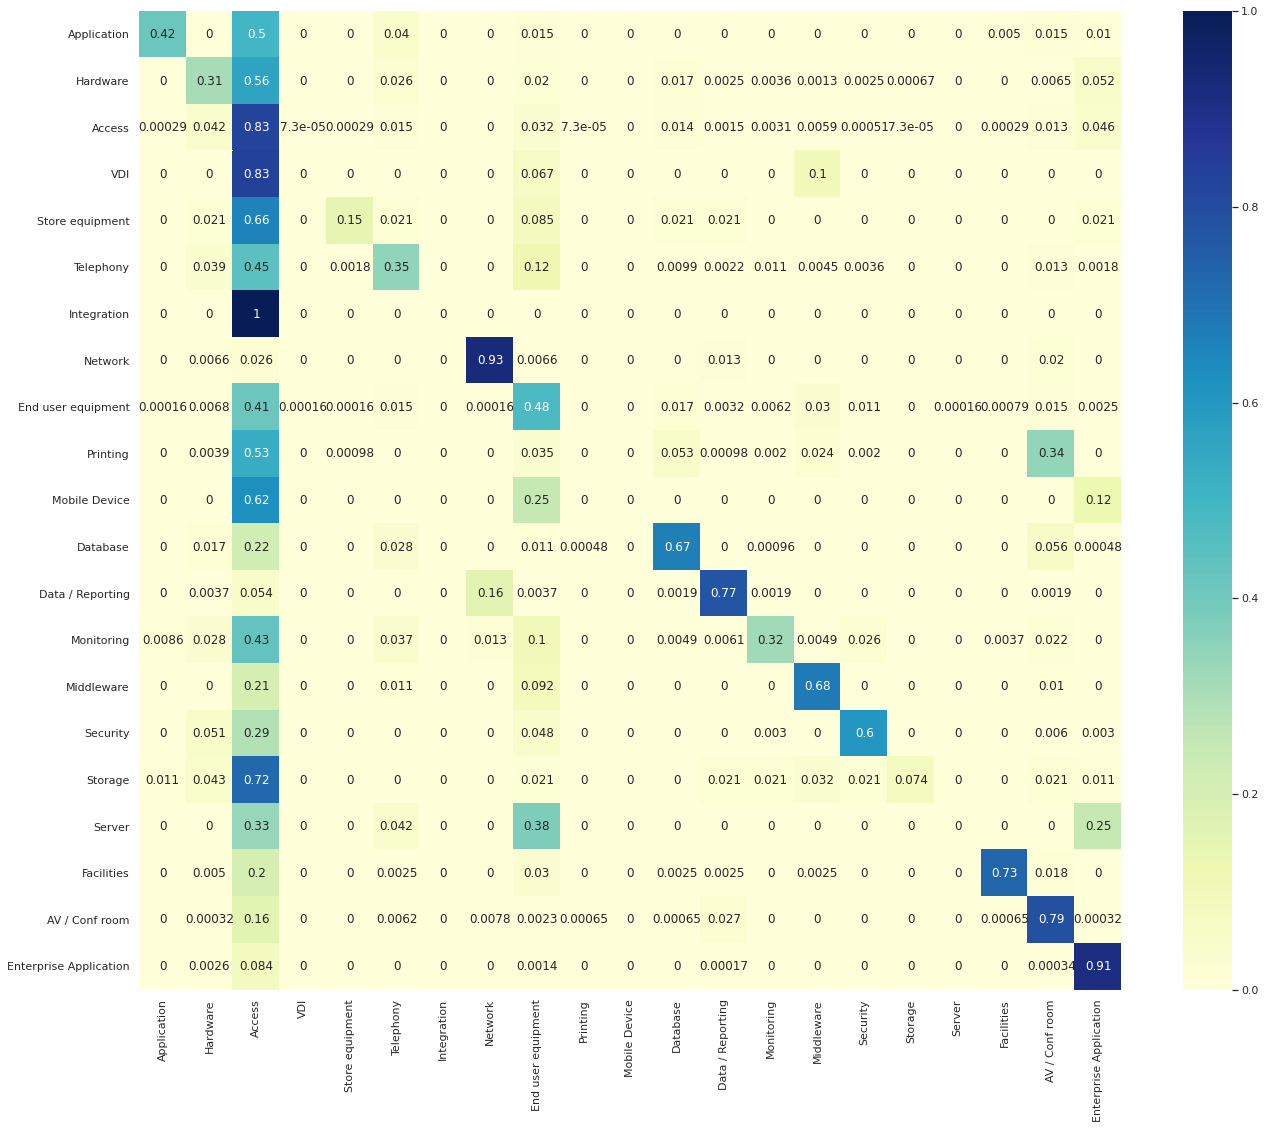

In [ ]:
labels = df2['category'].unique()
cm=metrics.confusion_matrix(y_test, y_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
fig_size=(22,18)
sns.set(rc={'figure.figsize':fig_size})
sns.heatmap(cm, 
    xticklabels=labels,
    yticklabels=labels,
        annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

# without cv tfidf

In [ ]:
clf = XGBClassifier(random_state=42, objective="softmax")

In [ ]:
param_grid = {
     'clf__n_estimators': [50,100,300]
     #'lambda': 
     #'clf__colsample_bytree': [0.6,0.8,1]
     #'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

grid_search = GridSearchCV(estimator = clf, cv = 3, param_grid = param_grid)

In [ ]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='softmax',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=2, silent=None,
                                     subsample=0.7, verbosity=1),
             iid='deprecated', n_jobs=1,
             param_grid={'clf__n_estimators': [50, 100, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [ ]:
grid_search.best_params_
clf_test = grid_search.best_estimator_

In [ ]:
preds = clf_test.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test, preds)

0.6543867120954003

In [ ]:
print(metrics.classification_report(y_test, preds))

                        precision    recall  f1-score   support

        AV / Conf room       0.96      0.38      0.55       201
                Access       0.63      0.31      0.41      4452
           Application       0.55      0.83      0.66     13747
      Data / Reporting       0.00      0.00      0.00        30
              Database       0.27      0.09      0.13        47
    End user equipment       0.59      0.34      0.43      2232
Enterprise Application       0.00      0.00      0.00         2
            Facilities       0.54      0.93      0.68       151
              Hardware       0.74      0.48      0.58      6306
           Integration       0.00      0.00      0.00      1025
            Middleware       0.00      0.00      0.00         8
         Mobile Device       0.75      0.67      0.71      2075
            Monitoring       0.74      0.77      0.76       536
               Network       0.66      0.31      0.42       815
              Printing       0.65      

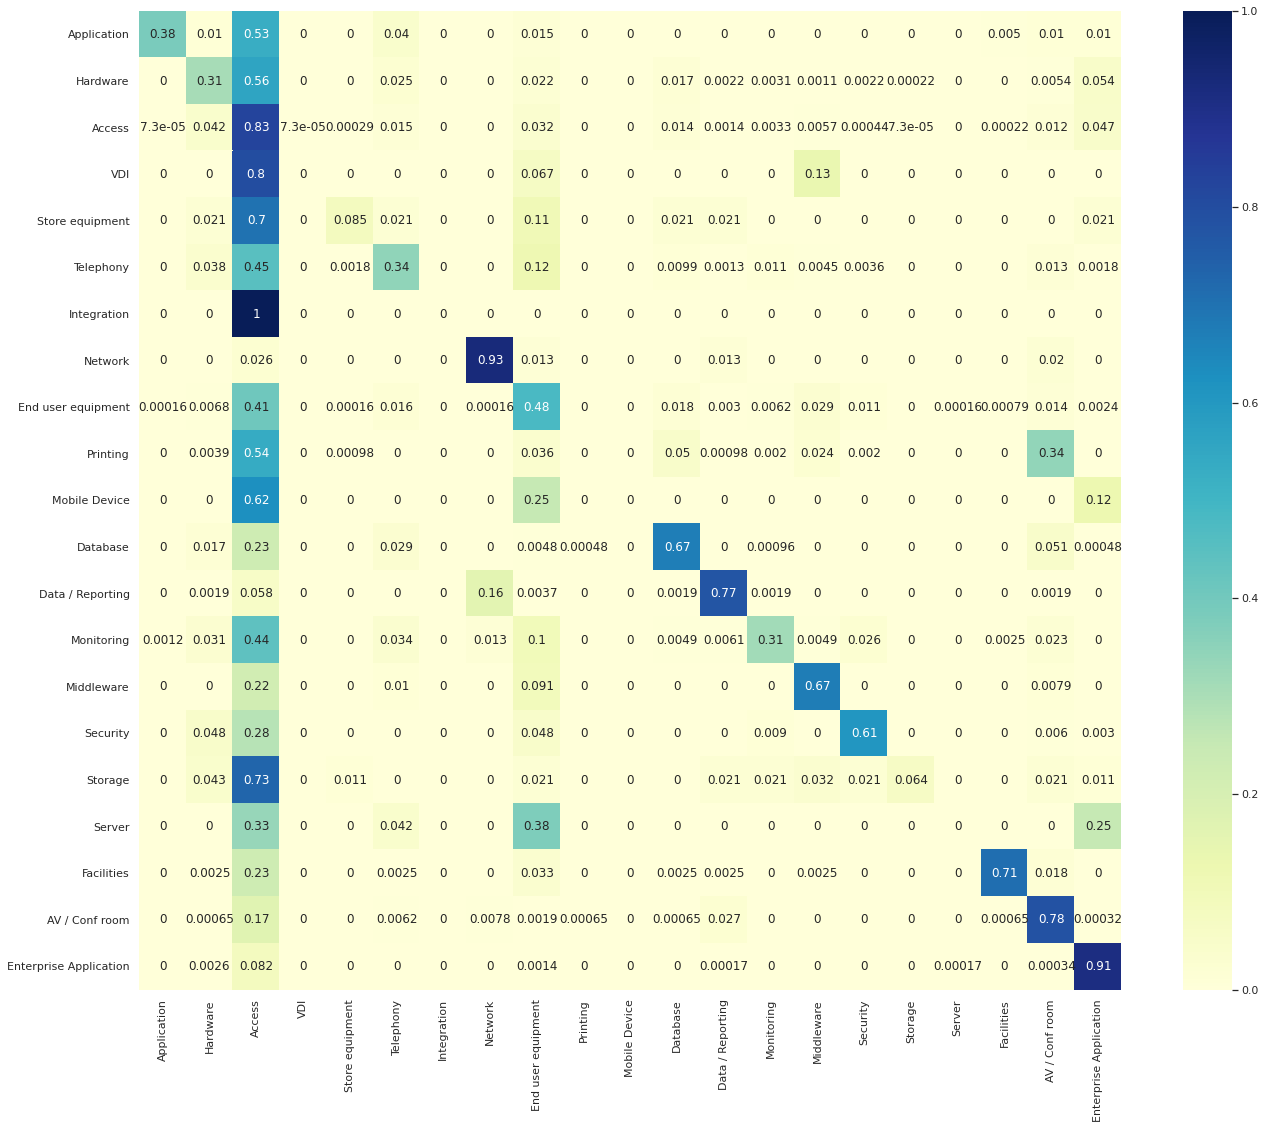

In [ ]:
labels = df2['category'].unique()
cm=metrics.confusion_matrix(y_test, preds)
cm = cm / np.sum(cm, axis=1)[:,None]
fig_size=(22,18)
sns.set(rc={'figure.figsize':fig_size})
sns.heatmap(cm, 
    xticklabels=labels,
    yticklabels=labels,
        annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

# Catboost

In [ ]:
pip install catboost

     |████████████████████████████████| 67.3MB 128kB/s 


In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
train, test = train_test_split(df2, test_size = 0.33, random_state=42)
X = train.drop(['category'], axis=1)
y = train['category']
x_train, x_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=42)

x_test = test.drop(['category'], axis=1)
y_test = test['category']

In [ ]:
text_features = ['short_description']
train_pool = Pool(
    x_train,
    y_train,
    text_features = text_features,
    feature_names = list(x_train)
)


valid_pool = Pool(
    x_valid,
    y_valid,
    text_features = text_features,
    feature_names = list(x_valid)
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 1000,
    'od_type': 'Iter',
    'use_best_model': True
}

cmodel = CatBoostClassifier(**catboost_params)

In [ ]:
#text_features = [0]
cmodel.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7404309	best: 0.7404309 (0)	total: 6.77s	remaining: 5h 38m 33s
1:	test: 0.7599863	best: 0.7599863 (1)	total: 13.5s	remaining: 5h 36m 17s
2:	test: 0.7755948	best: 0.7755948 (2)	total: 20.2s	remaining: 5h 36m 38s
3:	test: 0.7757516	best: 0.7757516 (3)	total: 27s	remaining: 5h 37m 39s
4:	test: 0.7750908	best: 0.7757516 (3)	total: 33.7s	remaining: 5h 36m 52s
5:	test: 0.7791875	best: 0.7791875 (5)	total: 40.6s	remaining: 5h 37m 18s
6:	test: 0.7811882	best: 0.7811882 (6)	total: 47.3s	remaining: 5h 36m 57s
7:	test: 0.7817664	best: 0.7817664 (7)	total: 54.2s	remaining: 5h 38m
8:	test: 0.7832670	best: 0.7832670 (8)	total: 1m	remaining: 5h 37m 33s
9:	test: 0.7828157	best: 0.7832670 (8)	total: 1m 7s	remaining: 5h 37m 30s
10:	test: 0.7885318	best: 0.7885318 (10)	total: 1m 14s	remaining: 5h 36m 58s
11:	test: 0.7884396	best: 0.7885318 (10)	total: 1m 21s	remaining: 5h 37m 36s
12:	test: 0.7881205	best: 0.7885318 (10)	total: 1m 27s	remaining: 5h 36m 47s
13:	test: 0.7876343	best: 0.7885318 (1

In [ ]:
cmodel.save_model(fname="catboost1")

In [ ]:
y_pred = cmodel.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.7139384813938482

In [ ]:
print(metrics.classification_report(y, y_pred))

                        precision    recall  f1-score   support

        AV / Conf room       0.86      0.53      0.65       220
                Access       0.61      0.42      0.50      4918
           Application       0.68      0.78      0.73     15107
      Data / Reporting       0.00      0.00      0.00        33
              Database       0.00      0.00      0.00        56
    End user equipment       0.63      0.37      0.46      2452
Enterprise Application       0.00      0.00      0.00         2
            Facilities       0.59      0.81      0.68       171
              Hardware       0.69      0.74      0.71      6940
           Integration       0.33      0.01      0.01      1128
            Middleware       0.00      0.00      0.00         9
         Mobile Device       0.71      0.81      0.76      2265
            Monitoring       0.73      0.83      0.77       588
               Network       0.54      0.51      0.52       893
              Printing       0.68      

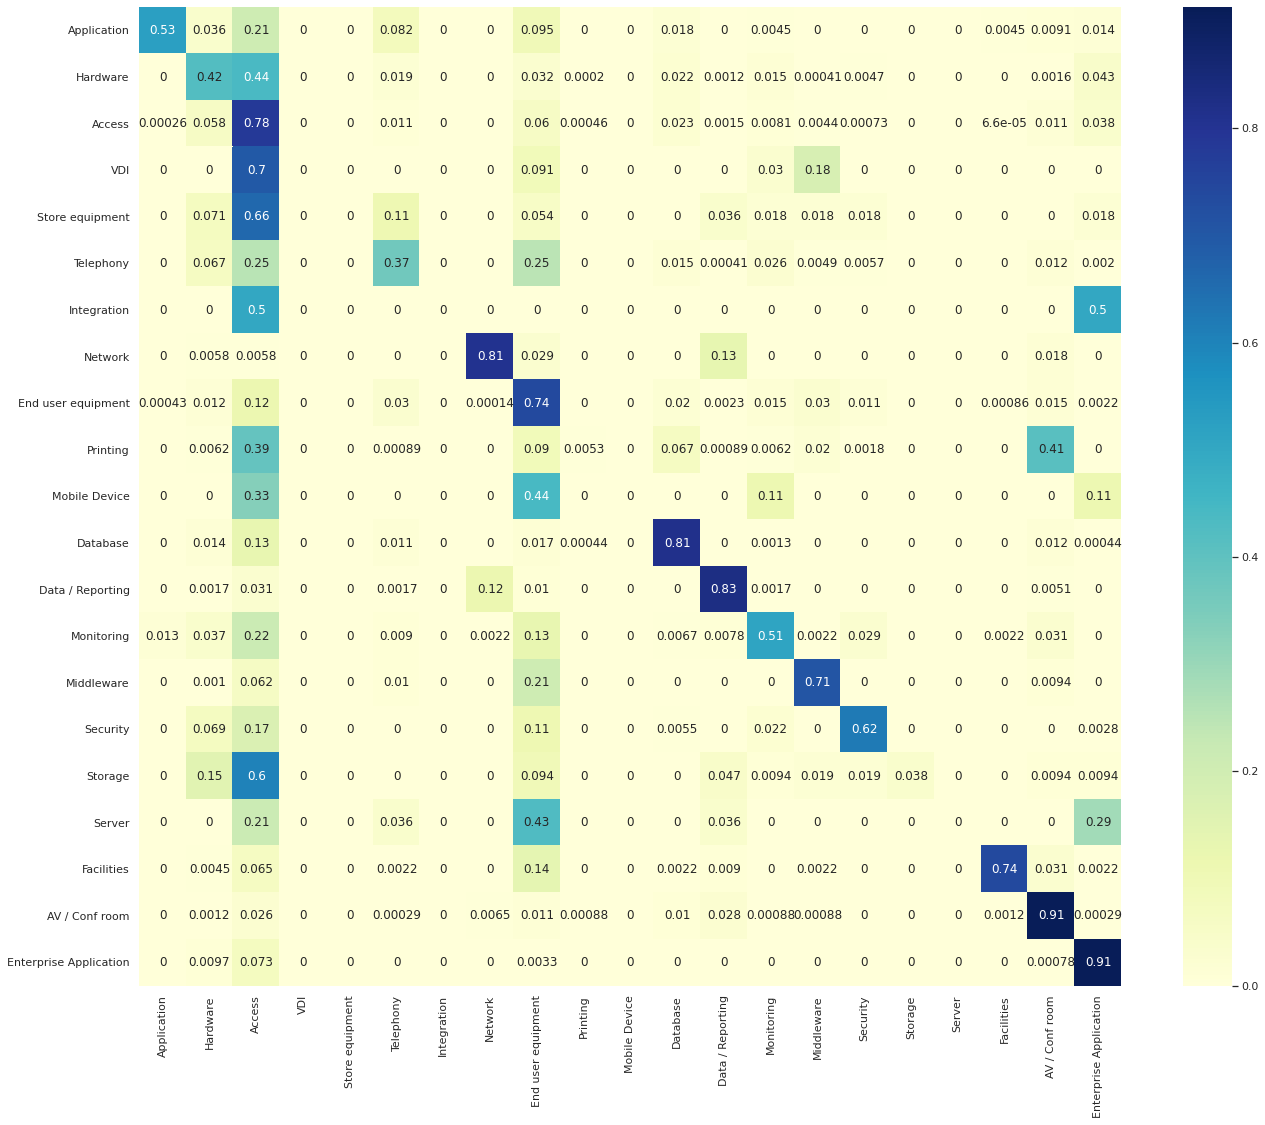

In [ ]:
labels = df2['category'].unique()
cm=metrics.confusion_matrix(y_test, y_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
fig_size=(22,18)
sns.set(rc={'figure.figsize':fig_size})
sns.heatmap(cm, 
    xticklabels=labels,
    yticklabels=labels,
        annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

In [ ]:
from_file = CatBoostClassifier()
from_file.load_model("catboost1")

In [ ]:
yp = from_file.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test, yp)

0.7139384813938482

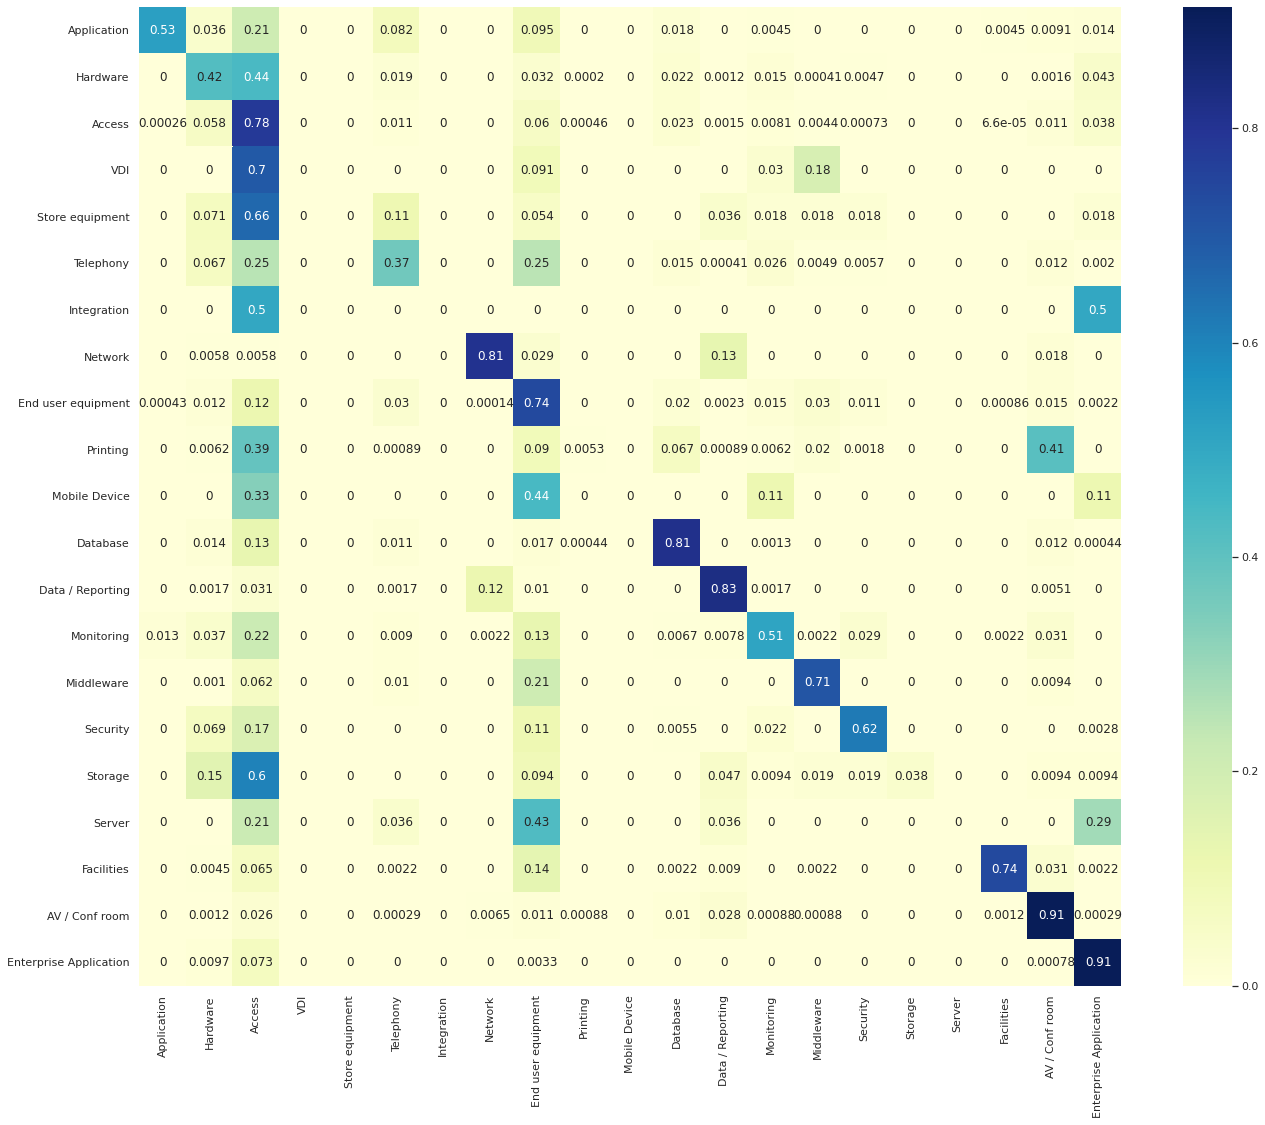

In [ ]:
labels = df2['category'].unique()
cm=metrics.confusion_matrix(y_test, yp)
cm = cm / np.sum(cm, axis=1)[:,None]
fig_size=(22,18)
sns.set(rc={'figure.figsize':fig_size})
sns.heatmap(cm, 
    xticklabels=labels,
    yticklabels=labels,
        annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

# Gird Search

In [ ]:
df2

category                                  short_description
0       Application  getting repeted sign-in dialogs in browser and...
1       Application            Wifi adapter not connecting to network.
2       Application  When im not on vpn my wifi speed is 40-50 Mbps...
3       Application  Lost me vpn google Authenticator key , how can...
4       Application  Hi Team, I'm opening this service ticket on be...
...             ...                                                ...
141027          VDI                                          VDI Login
141028          VDI                                          VDI Login
141029          VDI  VDI - Unable to login to VDI; Error: Desktop i...
141030          VDI                                   VDI Login Issues
141031          VDI  VDI - Unable to login to VDI; Error: Loading f...

[140877 rows x 2 columns]

In [ ]:
text_features = ['short_description']
train, test = train_test_split(df2, test_size = 0.33, random_state=42)
X = train.drop(['category'], axis=1)
y = train['category']
x_train, x_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=42)

x_test = test.drop(['category'], axis=1)
y_test = test['category']

In [ ]:
cmodel1 = CatBoostClassifier(custom_metric='AUC:hints=skip_train~false', text_features=text_features)
grid = {'learning_rate': [0.01, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5],
        'iterations': [2000]}
text_features = ['short_description']

grid_search_result = cmodel1.grid_search(grid, 
                                       x_train, 
                                       y_train,
                                       cv = 3, 
                                       plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
1016:	learn: 2.1250355	test: 2.1253049	best: 2.1249654 (64)	total: 1m 58s	remaining: 1m 54s
1017:	learn: 2.1250355	test: 2.1253049	best: 2.1249654 (64)	total: 1m 58s	remaining: 1m 54s
1018:	learn: 2.1250355	test: 2.1253050	best: 2.1249654 (64)	total: 1m 58s	remaining: 1m 54s
1019:	learn: 2.1250354	test: 2.1253051	best: 2.1249654 (64)	total: 1m 58s	remaining: 1m 54s
1020:	learn: 2.1250354	test: 2.1253052	best: 2.1249654 (64)	total: 1m 58s	remaining: 1m 54s
1021:	learn: 2.1250354	test: 2.1253053	best: 2.1249654 (64)	total: 1m 59s	remaining: 1m 53s
1022:	learn: 2.1250354	test: 2.1253053	best: 2.1249654 (64)	total: 1m 59s	remaining: 1m 53s
1023:	learn: 2.1250354	test: 2.1253054	best: 2.1249654 (64)	total: 1m 59s	remaining: 1m 53s
1024:	learn: 2.1250354	test: 2.1253055	best: 2.1249654 (64)	total: 1m 59s	remaining: 1m 53s
1025:	learn: 2.1250354	test: 2.1253056	best: 2.1249654 (64)	total: 1m 59s	remaining: 1m 53s
1026:	learn: 2.1250354	test: 

0:	learn: 2.8042728	test: 2.8042728	best: 2.8042728 (0)
1:	learn: 2.6686443	test: 2.6686443	best: 2.6686443 (1)
2:	learn: 2.5725241	test: 2.5725241	best: 2.5725241 (2)	total: 1.15s	remaining: 12m 46s
3:	learn: 2.4993207	test: 2.4993207	best: 2.4993207 (3)
4:	learn: 2.4413878	test: 2.4413878	best: 2.4413878 (4)
5:	learn: 2.3944131	test: 2.3944131	best: 2.3944131 (5)
6:	learn: 2.3556797	test: 2.3556798	best: 2.3556798 (6)	total: 2.57s	remaining: 12m 12s
7:	learn: 2.3233485	test: 2.3233485	best: 2.3233485 (7)
8:	learn: 2.2961098	test: 2.2961099	best: 2.2961099 (8)
9:	learn: 2.2729958	test: 2.2729959	best: 2.2729959 (9)
10:	learn: 2.2532696	test: 2.2532697	best: 2.2532697 (10)	total: 3.92s	remaining: 11m 48s
11:	learn: 2.2363573	test: 2.2363574	best: 2.2363574 (11)
12:	learn: 2.2218034	test: 2.2218035	best: 2.2218035 (12)
13:	learn: 2.2092408	test: 2.2092409	best: 2.2092409 (13)
14:	learn: 2.1983699	test: 2.1983700	best: 2.1983700 (14)	total: 5.33s	remaining: 11m 45s
15:	learn: 2.1889436	t

In [ ]:
grid_search_result['params']

{'depth': 4, 'iterations': 2000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [ ]:
ypg = cmodel1.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test, ypg)

0.7185631318563132

In [ ]:
cmodel1.save_model(fname="caboost.gs")

In [ ]:
print(metrics.classification_report(y_test, ypg))

                        precision    recall  f1-score   support

        AV / Conf room       0.86      0.60      0.70       220
                Access       0.63      0.42      0.50      4918
           Application       0.69      0.79      0.74     15107
      Data / Reporting       0.00      0.00      0.00        33
              Database       0.33      0.07      0.12        56
    End user equipment       0.63      0.37      0.47      2452
Enterprise Application       0.00      0.00      0.00         2
            Facilities       0.59      0.89      0.71       171
              Hardware       0.69      0.75      0.72      6940
           Integration       0.41      0.04      0.08      1128
            Middleware       0.00      0.00      0.00         9
         Mobile Device       0.72      0.82      0.76      2265
            Monitoring       0.74      0.82      0.78       588
               Network       0.56      0.51      0.54       893
              Printing       0.67      

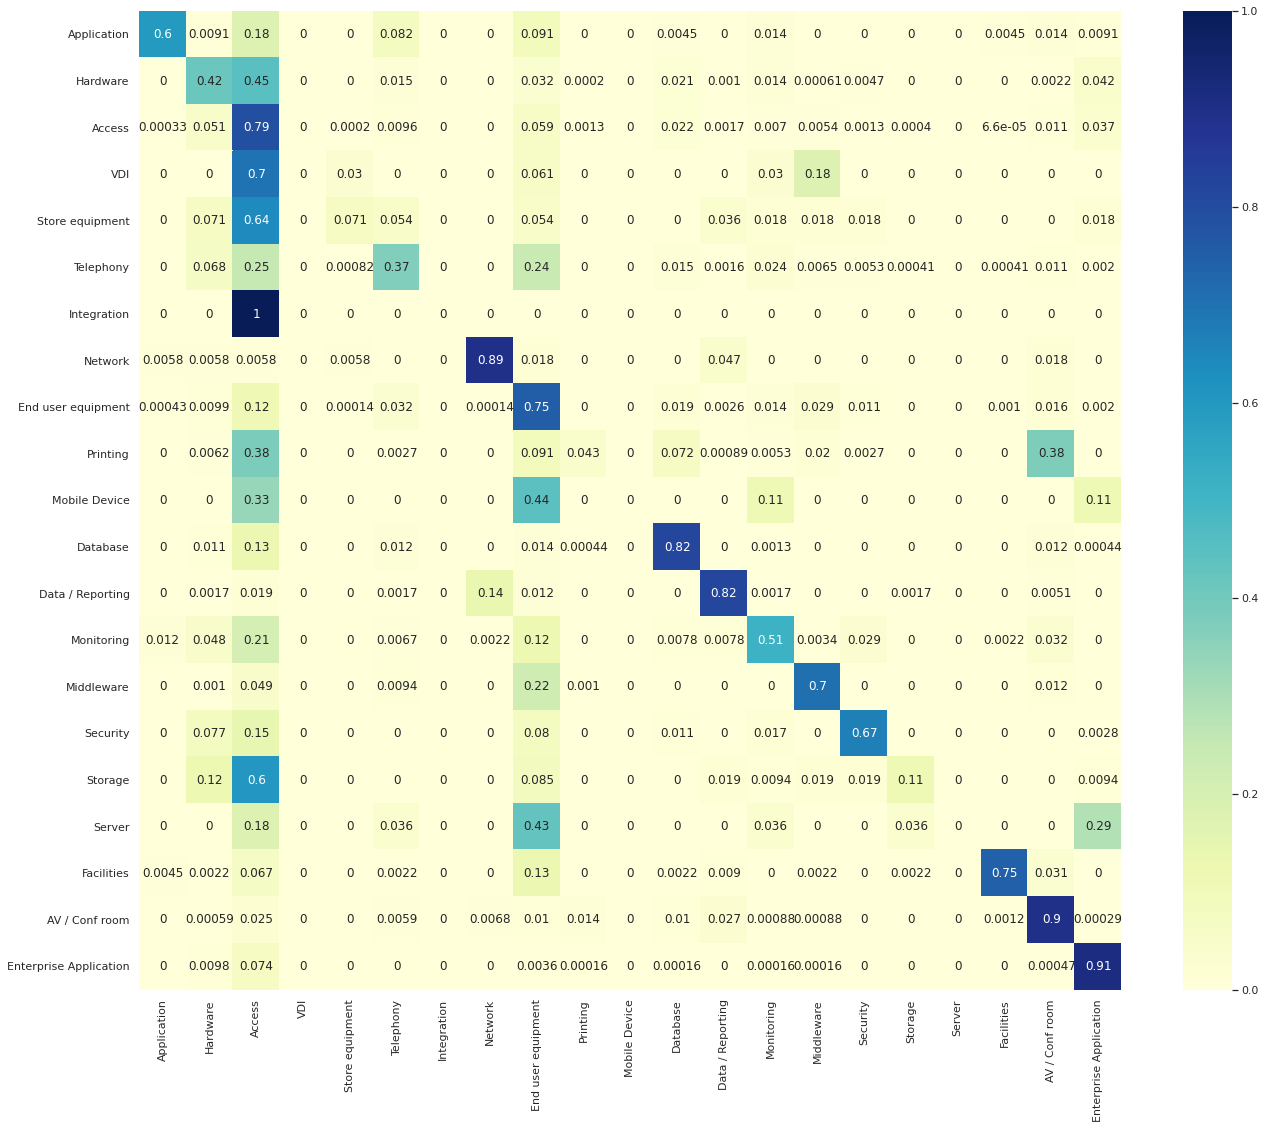

In [ ]:
labels = df2['category'].unique()
cm=metrics.confusion_matrix(y_test, ypg)
cm = cm / np.sum(cm, axis=1)[:,None]
fig_size=(22,18)
sns.set(rc={'figure.figsize':fig_size})
sns.heatmap(cm, 
    xticklabels=labels,
    yticklabels=labels,
        annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

# Binning Categories

# Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
df2['category'].value_counts()

Application               45674
Hardware                  21088
VDI                       19196
Access                    15019
Telephony                 10240
End user equipment         7456
Mobile Device              6874
Integration                3492
Printing                   2919
Network                    2656
Monitoring                 1807
Store equipment            1346
Security                   1204
AV / Conf room              675
Facilities                  525
Server                      309
Database                    181
Data / Reporting            100
Storage                      82
Middleware                   31
Enterprise Application        3
Name: category, dtype: int64

In [ ]:
(df2['category'].value_counts()[5:].sum())/(len(df2['category'].unique())-5)

1853.75

In [ ]:
sampling = {"Application":1853, "Hardware":1853, "VDI":1853, "Access":1853,
            "Telephony":1853, "End user equipment":1853, "Mobile Device":1853}

In [ ]:
df3=df2
X = df3.drop(['category'], axis=1)
y = df3['category']
under = RandomUnderSampler(sampling_strategy=sampling)
x_under,y_under = under.fit_resample(X,y)

df3 = pd.DataFrame()
df3['category'] = y_under
df3['short_description'] = x_under

In [ ]:
df3['category'][df3['category']== "Storage"] = "other"
df3['category'][df3['category']== "Middleware"] = "other"
df3['category'][df3['category']== "Enterprise Application"] = "other"

In [ ]:
df3['category'].value_counts()

Integration           3492
Printing              2919
Network               2656
Hardware              1853
VDI                   1853
End user equipment    1853
Application           1853
Access                1853
Telephony             1853
Mobile Device         1853
Monitoring            1807
Store equipment       1346
Security              1204
AV / Conf room         675
Facilities             525
Server                 309
Database               181
other                  116
Data / Reporting       100
Name: category, dtype: int64

# Catboost with undersampled dataset

In [ ]:
train_u, test_u = train_test_split(df3, test_size = 0.33, random_state=42)
X_u = train_u.drop(['category'], axis=1)
y_u = train_u['category']
x_train_u, x_valid_u, y_train_u, y_valid_u = train_test_split(X_u,y_u, test_size=0.3, random_state=42)

x_test_u = test_u.drop(['category'], axis=1)
y_test_u = test_u['category']

In [ ]:
text_features = ['short_description']
train_pool = Pool(
    x_train_u,
    y_train_u,
    text_features = text_features,
    feature_names = list(x_train_u)
)


valid_pool = Pool(
    x_valid_u,
    y_valid_u,
    text_features = text_features,
    feature_names = list(x_valid_u)
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 1000,
    'od_type': 'Iter',
    'use_best_model': True
}

cmodel2 = CatBoostClassifier(**catboost_params)

In [ ]:
cmodelu.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7098817	best: 0.7098817 (0)	total: 2.77s	remaining: 2h 18m 34s
1:	test: 0.7742069	best: 0.7742069 (1)	total: 5.46s	remaining: 2h 16m 20s
2:	test: 0.8124453	best: 0.8124453 (2)	total: 8.15s	remaining: 2h 15m 46s
3:	test: 0.8141501	best: 0.8141501 (3)	total: 10.8s	remaining: 2h 15m 25s
4:	test: 0.8422813	best: 0.8422813 (4)	total: 13.5s	remaining: 2h 15m 14s
5:	test: 0.8432287	best: 0.8432287 (5)	total: 16.2s	remaining: 2h 14m 53s
6:	test: 0.8669591	best: 0.8669591 (6)	total: 18.9s	remaining: 2h 14m 46s
7:	test: 0.8846299	best: 0.8846299 (7)	total: 21.6s	remaining: 2h 14m 45s
8:	test: 0.8833917	best: 0.8846299 (7)	total: 24.4s	remaining: 2h 14m 58s
9:	test: 0.8913736	best: 0.8913736 (9)	total: 27.1s	remaining: 2h 15m
10:	test: 0.8962431	best: 0.8962431 (10)	total: 29.8s	remaining: 2h 14m 51s
11:	test: 0.8958780	best: 0.8962431 (10)	total: 32.5s	remaining: 2h 14m 43s
12:	test: 0.8969156	best: 0.8969156 (12)	total: 35.1s	remaining: 2h 14m 28s
13:	test: 0.8970876	best: 0.8970876 

In [ ]:
cmodelu.save_model(fname="undersampled_cb_notgood_savedjustincase")

In [ ]:
ypu = cmodelu.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test_u, ypu)

0.656423982869379

In [ ]:
print(metrics.classification_report(y_test_u, ypu))

                    precision    recall  f1-score   support

    AV / Conf room       0.83      0.67      0.74       223
            Access       0.42      0.51      0.46       591
       Application       0.41      0.35      0.38       635
  Data / Reporting       0.00      0.00      0.00        39
          Database       0.00      0.00      0.00        51
End user equipment       0.56      0.50      0.53       595
        Facilities       0.64      0.90      0.75       176
          Hardware       0.47      0.56      0.51       621
       Integration       0.50      0.56      0.53      1174
     Mobile Device       0.75      0.74      0.75       604
        Monitoring       0.92      0.82      0.87       630
           Network       0.71      0.75      0.73       848
          Printing       0.85      0.89      0.87       973
          Security       0.76      0.69      0.72       401
            Server       0.50      0.07      0.12        84
   Store equipment       0.90      0.81

In [ ]:
ypu2 = cmodelu.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test, ypu2)

0.5578403957840395

In [ ]:
print(metrics.classification_report(y_test, ypu2))

                        precision    recall  f1-score   support

        AV / Conf room       0.55      0.75      0.63       220
                Access       0.42      0.53      0.47      4918
           Application       0.78      0.33      0.47     15107
      Data / Reporting       0.00      0.00      0.00        33
              Database       0.20      0.02      0.03        56
    End user equipment       0.39      0.50      0.44      2452
Enterprise Application       0.00      0.00      0.00         2
            Facilities       0.57      0.92      0.70       171
              Hardware       0.66      0.56      0.61      6940
           Integration       0.12      0.62      0.21      1128
            Middleware       0.00      0.00      0.00         9
         Mobile Device       0.66      0.75      0.70      2265
            Monitoring       0.70      0.81      0.75       588
               Network       0.27      0.77      0.40       893
              Printing       0.44      